In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix


C:\Users\User\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [108]:
train_data1 = pd.read_csv('train_ver_2.csv')
test_data1 = pd.read_csv('test_ver_2.csv')

bins = [0,40,50,60,70,200]
labels = ['20,30대','40대','50대','60대','70대 이상']

train_data1['Age_group'] = pd.cut(train_data1['Age'], bins = bins, labels = labels)
test_data1['Age_group'] = pd.cut(test_data1['Age'], bins = bins, labels = labels)
    

# Train 데이터를 Train과 Validation 세트로 나누기
X_train1, X_val1, y_train1, y_val1 = train_test_split(train_data1.drop(columns=['Response']),
                                                  train_data1['Response'],
                                                  test_size=0.2,
                                                  stratify=train_data1['Response'],
                                                  random_state = 31)

# under sampling용 변수 설정
np.random.seed(42)
X_train1['group'] = np.where(y_train1 == 1, 0, np.random.randint(1, 7, size=len(y_train1)))


In [40]:
y_train2 = y_train1[X_train1[(X_train1['group'].isin([0,1]))].index]
y_train2

524     1
1247    1
1361    1
700     0
1615    1
       ..
1452    1
433     1
1199    1
48      1
1696    0
Name: Response, Length: 421, dtype: object

In [51]:
hyper_param = pd.DataFrame(columns=['C', 'solver', 'penalty', 'max_iter', 'tol', 'score']);
hyper_param.append([1,2,3,4,5,6])

0    C max_iter penalty score solver  tol
0  1.0  NaN      NaN     NaN   NaN    NaN  NaN
1  2.0  NaN      NaN     NaN   NaN    NaN  NaN
2  3.0  NaN      NaN     NaN   NaN    NaN  NaN
3  4.0  NaN      NaN     NaN   NaN    NaN  NaN
4  5.0  NaN      NaN     NaN   NaN    NaN  NaN
5  6.0  NaN      NaN     NaN   NaN    NaN  NaN

In [124]:
hyper_param = pd.DataFrame(columns=['C', 'solver', 'penalty', 'max_iter', 'tol'])
target = []
for i in range(1,7):
    train = X_train1[(X_train1['group'].isin([0,i]))]
    y = y_train1[train.index]
    
    categorical_cols = ['Education', 'Marital_Status']
    numeric_cols = [col for col in train.columns if col not in ['Education', 'Marital_Status', 'Response', 'group', 'Age_group']]
    
    # standard scaler
    std_scale = StandardScaler()
    train_data_std = std_scale.fit_transform(train[numeric_cols])
    
    oh_encod = OneHotEncoder(sparse_output=False)
    train_data_enc = oh_encod.fit_transform(train[categorical_cols])
    
    # process dataset 
    processed_data = np.hstack((train_data_std, train_data_enc))

    
    processed_data = np.hstack((train_data_std, train_data_enc))

    def logistic_regression_cv2(C, solver, penalty, max_iter, tol):
        C = 10 ** C  # 로그 스케일 C 변환
        max_iter = int(max_iter)
        tol = 10 ** tol  # 로그 스케일 tol 변환
        penalty_options = ['l1', 'l2', None]  # 'none' 옵션 추가
        solver_options = ['liblinear', 'saga']

        # 범주형 매개변수 매핑
        penalty = penalty_options[int(penalty)]
        solver = solver_options[int(solver)]
        if penalty is None and solver not in ['lbfgs', 'newton-cg', 'sag', 'saga']:
            return 0 # 'None' 규제는 'liblinear'와 호환되지 않음

        # 모델 생성
        model = LogisticRegression(C=C, penalty=penalty, solver=solver, max_iter=max_iter, tol=tol, random_state=42)
    
        #cross_val_score를 사용하여 교차 검증을 수행, scoring을 'f1'으로 설정
        scores2 = cross_val_score(model, processed_data, y, cv=3, scoring='f1')
    
        # 평균 점수 반환
        return scores2.mean()
    
    # 베이지안 최적화의 파라미터 공간 정의
    params = {
        'C': (-6, 6),  # 로그 스케일로 C 파라미터 탐색
        'solver': (0, 1),  # 0 = 'liblinear', 1 = 'saga'
        'penalty': (0, 2),  # 0 = 'l1', 1 = 'l2', 2 = 'none'
        'max_iter': (10, 500),  # 정수 범위
        'tol': (-6, -1)  # 로그 스케일로 tol 파라미터 탐색
    }
    
    # BayesianOptimization 객체 생성
    optimizer2 = BayesianOptimization(
        f=logistic_regression_cv2,  # 최적화할 함수
        pbounds=params,            # 파라미터 범위
        random_state=42,
        verbose=2
    )
    

    # 최적화 수행
    optimizer2.maximize(
        init_points=5,   # 랜덤하게 탐색할 초기 포인트 수
        n_iter=25,       # 베이지안 최적화를 통해 탐색할 포인트 수
    )
    
    # 파라미터 정리
    penalty_options = ['l1', 'l2', None]
    solver_options = ['liblinear', 'saga']
    
    # f1 파라미터
    best_f1_C = 10 ** optimizer2.max['params']['C']
    best_f1_max_iter = int(round(optimizer2.max['params']['max_iter']))  # 반올림 후 정수 변환
    best_f1_penalty_index = int(round(optimizer2.max['params']['penalty']))  # 반올림 후 인덱스 변환
    best_f1_penalty = penalty_options[best_f1_penalty_index]
    best_f1_solver_index = int(round(optimizer2.max['params']['solver']))  # 반올림 후 인덱스 변환
    best_f1_solver = solver_options[best_f1_solver_index]
    best_f1_tol = 10 ** -optimizer2.max['params']['tol']  
    
    best_f1 = {
        'C': best_f1_C,
        'max_iter': best_f1_max_iter,
        'penalty': best_f1_penalty,
        'solver': best_f1_solver,
        'tol': best_f1_tol
    }

    hyper_param = hyper_param.append(optimizer2.max['params'],ignore_index = True)
    target.append(optimizer2.max['target'])


|   iter    |  target   |     C     | max_iter  |  penalty  |  solver   |    tol    |
-------------------------------------------------------------------------------------
| 1         | 0.7547    | -1.506    | 475.9     | 1.464     | 0.5987    | -5.22     |
| 2         | 0.6503    | -4.128    | 38.46     | 1.732     | 0.6011    | -2.46     |
| 3         | 0.6436    | -5.753    | 485.3     | 1.665     | 0.2123    | -5.091    |
| 4         | 0.6503    | -3.799    | 159.1     | 1.05      | 0.4319    | -4.544    |
| 5         | 0.76      | 1.342     | 78.35     | 0.5843    | 0.3664    | -3.72     |
| 6         | 0.7411    | -1.355    | 348.6     | 0.5161    | 0.832     | -2.951    |
| 7         | 0.763     | 4.877     | 61.62     | 0.2945    | 0.9253    | -2.146    |
| 8         | 0.76      | 1.008     | 33.41     | 0.07162   | 0.1045    | -4.834    |
| 9         | 0.7583    | -0.3769   | 496.6     | 1.844     | 0.4318    | -4.422    |
| 10        | 0.76      | 3.691     | 96.14     | 0.63

| 26        | 0.8041    | -6.0      | 81.87     | 2.0       | 1.0       | -6.0      |
| 27        | 0.7877    | -6.0      | 73.67     | 2.0       | 1.0       | -1.0      |
| 28        | 0.0       | 4.743     | 118.2     | 2.0       | 0.0       | -1.0      |
| 29        | 0.8041    | 0.06714   | 69.7      | 2.0       | 1.0       | -6.0      |
| 30        | 0.0       | -4.607    | 64.03     | 0.0       | 0.0       | -1.0      |
|   iter    |  target   |     C     | max_iter  |  penalty  |  solver   |    tol    |
-------------------------------------------------------------------------------------
| 1         | 0.7555    | -1.506    | 475.9     | 1.464     | 0.5987    | -5.22     |
| 2         | 0.6453    | -4.128    | 38.46     | 1.732     | 0.6011    | -2.46     |
| 3         | 0.6453    | -5.753    | 485.3     | 1.665     | 0.2123    | -5.091    |
| 4         | 0.6531    | -3.799    | 159.1     | 1.05      | 0.4319    | -4.544    |
| 5         | 0.7517    | 1.342     | 78.35     | 0.58

| 20        | 0.6629    | -4.841    | 319.3     | 1.044     | 0.5143    | -3.807    |
| 21        | 0.804     | 5.157     | 341.1     | 0.6338    | 0.9513    | -1.104    |
| 22        | 0.0       | -6.0      | 351.7     | 0.0       | 0.0       | -6.0      |
| 23        | 0.798     | 6.0       | 329.4     | 0.0       | 1.0       | -1.0      |
| 24        | 0.798     | 6.0       | 175.8     | 2.0       | 1.0       | -1.0      |
| 25        | 0.0       | -5.595    | 181.2     | 0.4733    | 0.05888   | -4.871    |
| 26        | 0.806     | 6.0       | 165.1     | 0.0       | 0.0       | -1.0      |
| 27        | 0.8067    | 6.0       | 47.32     | 0.0       | 1.0       | -6.0      |
| 28        | 0.8001    | 5.761     | 20.91     | 0.002886  | 0.8513    | -5.006    |
| 29        | 0.6629    | -5.695    | 10.03     | 1.195     | 0.9699    | -2.91     |
| 30        | 0.798     | 6.0       | 398.5     | 2.0       | 1.0       | -1.0      |
|   iter    |  target   |     C     | max_iter  |  pen

| 15        | 0.7888    | 4.198     | 461.2     | 0.9467    | 0.2617    | -5.066    |
| 16        | 0.6697    | -3.172    | 464.0     | 1.55      | 0.2843    | -5.209    |
| 17        | 0.7888    | 5.862     | 454.4     | 1.728     | 0.7972    | -3.687    |
| 18        | 0.7888    | 4.922     | 446.9     | 1.218     | 0.842     | -5.895    |
| 19        | 0.7426    | -1.141    | 449.3     | 0.9744    | 0.09983   | -1.931    |
| 20        | 0.7916    | 6.0       | 439.3     | 2.0       | 1.0       | -6.0      |
| 21        | 0.7946    | -1.248    | 437.1     | 1.49      | 0.5789    | -5.745    |
| 22        | 0.7962    | 3.436     | 433.9     | 0.0       | 0.0       | -1.0      |
| 23        | 0.7888    | 0.4079    | 429.2     | 1.766     | 0.7139    | -5.995    |
| 24        | 0.0       | -5.517    | 431.9     | 0.0       | 0.0       | -1.0      |
| 25        | 0.7916    | 6.0       | 431.8     | 2.0       | 1.0       | -6.0      |
| 26        | 0.7888    | 5.108     | 422.4     | 0.40

In [146]:
hyper_param['target'] = target
final_params = hyper_param.loc[hyper_param['target'].idxmax()]

categorical_cols = ['Education', 'Marital_Status']
numeric_cols = [col for col in train_data1.columns if col not in ['Education', 'Marital_Status', 'Response', 'group', 'Age_group']]

test_scale = std_scale.transform(test_data1[numeric_cols])
test_encod = oh_encod.transform(test_data1[categorical_cols])

test_processed_data = np.hstack((test_scale, test_encod))
y_test = test_data1['Response']
final_params

C            6.000000
solver       1.000000
penalty      0.000000
max_iter    47.324245
tol         -6.000000
target       0.806707
Name: 3, dtype: float64

In [219]:
best_C

1000000.0

F1-Score on Test Data: 0.4489795918367347
AUC on Test Data: 0.7891884268214056


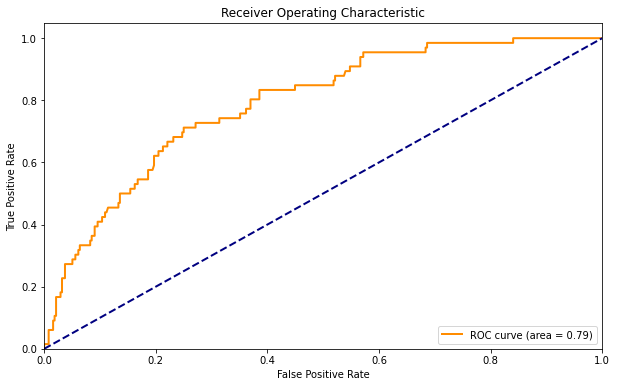

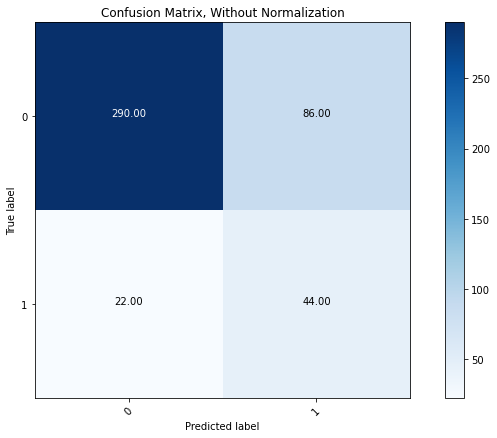

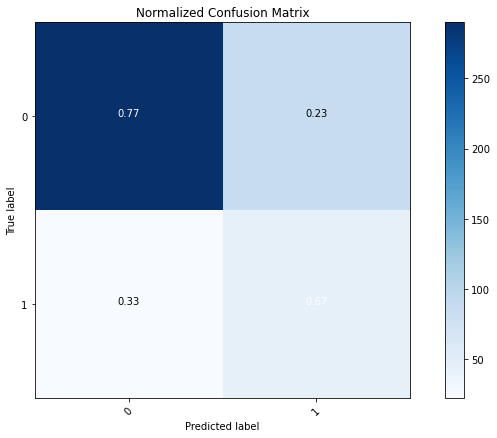

              precision    recall  f1-score   support

           0       0.93      0.77      0.84       376
           1       0.34      0.67      0.45        66

    accuracy                           0.76       442
   macro avg       0.63      0.72      0.65       442
weighted avg       0.84      0.76      0.78       442



In [220]:
best_C=10 **final_params['C']
best_auc_penalty_index=int(round(final_params['penalty']))
best_auc_penalty = penalty_options[best_auc_penalty_index]
best_auc_solver_index = int(round(final_params['solver']))# 반올림 후 인덱스 변환
best_auc_solver = solver_options[best_auc_solver_index]
best_max_iter=int(round(final_params['max_iter']))
best_tol=10 ** -final_params['tol']

model_auc = LogisticRegression(
    C=best_C,
    penalty=best_auc_penalty,
    solver=best_auc_solver,
    max_iter=best_max_iter,
    tol=best_tol,
    random_state=42
)

train = X_train1[(X_train1['group'].isin([0,hyper_param['target'].idxmax()]))]
y = y_train1[train.index]

categorical_cols = ['Education', 'Marital_Status']
numeric_cols = [col for col in train.columns if col not in ['Education', 'Marital_Status', 'Response', 'group', 'Age_group']]

# standard scaler
std_scale = StandardScaler()
train_data_std = std_scale.fit_transform(train[numeric_cols])

oh_encod = OneHotEncoder(sparse_output=False)
train_data_enc = oh_encod.fit_transform(train[categorical_cols])

# process dataset 
processed_data = np.hstack((train_data_std, train_data_enc))

model_auc.fit(processed_data, y)
y_auc_pred = model_auc.predict(test_processed_data)
y_pred_proba = model_auc.predict_proba(test_processed_data)[:, 1]


f1 = f1_score(y_test, y_auc_pred)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"F1-Score on Test Data: {f1}")
print(f"AUC on Test Data: {auc}")

plt.figure(figsize = (10,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

cm = confusion_matrix(y_test, model_auc.predict(test_processed_data))

def plot_conf_matrix(cm, classes,
                      normalize=False,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = ['0', '1']

# 시각화 실행
plt.figure(figsize = (10,6))
plot_conf_matrix(cm, classes=class_names,
                 title='Confusion Matrix, Without Normalization')

# 정규화된 혼동 행렬 시각화도 가능
plt.figure(figsize = (10,6))
plot_conf_matrix(cm, classes=class_names, normalize=True,
                 title='Normalized Confusion Matrix')

plt.show()

from sklearn.metrics import classification_report

target_names = ['0', '1']
print(classification_report(y_test, y_auc_pred, 
                            target_names=target_names))

In [201]:
y

428     0
1530    0
1117    0
701     0
1495    0
       ..
1606    1
1452    1
433     1
1199    1
48      1
Name: Response, Length: 404, dtype: int64

In [199]:
processed_data

array([[-1.10233302,  1.138114  , -0.74897617, ...,  1.        ,
         0.        ,  0.        ],
       [-0.16670513, -0.75405907,  1.10738195, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.00411343, -0.75405907,  1.10738195, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.75030001, -0.75405907, -0.74897617, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.7388534 , -0.75405907, -0.74897617, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.13750344, -0.75405907, -0.74897617, ...,  1.        ,
         0.        ,  0.        ]])